# FLAI_Net Training

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Import Dataset

In [131]:
ds = pd.read_csv('../dataset/flai_data.csv')
ds = ds.sort_values('label')
ds.head()

,user,label,coordinate 0,coordinate 1,coordinate 2,coordinate 3,coordinate 4,coordinate 5,coordinate 6,coordinate 7,...,coordinate 53,coordinate 54,coordinate 55,coordinate 56,coordinate 57,coordinate 58,coordinate 59,coordinate 60,coordinate 61,coordinate 62
0,lea,a,0.699433,0.694308,-5.125001e-07,0.648201,0.623592,-0.013627,0.620721,0.537524,...,-0.021148,0.727923,0.482140,-0.033280,0.721847,0.531752,-0.020166,0.734710,0.541902,-0.006052
4213,Anja,a,0.783164,0.464943,-5.455665e-07,0.733808,0.431511,-0.019197,0.704531,0.340193,...,-0.008321,0.838835,0.222084,-0.023938,0.823087,0.259231,-0.016016,0.816125,0.291306,-0.004580
4212,Anja,a,0.700200,0.574718,-7.226926e-07,0.638045,0.514915,-0.025762,0.607924,0.389235,...,-0.009569,0.781731,0.262508,-0.027723,0.759230,0.302853,-0.019329,0.745885,0.341302,-0.006644
4211,Anja,a,0.664200,0.428078,-5.299640e-07,0.618430,0.382897,-0.028544,0.604768,0.283992,...,-0.018270,0.752735,0.191741,-0.033697,0.736050,0.223431,-0.026450,0.725282,0.251077,-0.016669
4210,Anja,a,0.783185,0.466400,-5.640823e-07,0.734548,0.430934,-0.018781,0.705763,0.336010,...,-0.008646,0.837997,0.221828,-0.023902,0.822437,0.259865,-0.015338,0.816671,0.290299,-0.003778


### Dataset Statistics

In [132]:
num_samples = len(ds)
num_contributors = len(pd.unique(ds.user))
classes = pd.unique(ds.label)
print(f'Samples: {num_samples}')
print(f'Unique contributors: {num_contributors}')
print(f'Classes: {classes}')

Samples: 5308
Unique contributors: 5
Classes: ['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's'
 't' 'u' 'v' 'w' 'x' 'y']


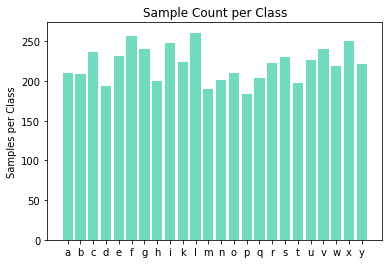

In [133]:
samples_per_label = ds.label.value_counts().sort_index()
color = (112/255, 219/255, 189/255)
x_pos = [i for i in range(len(samples_per_label.index))]
plt.bar(x_pos, samples_per_label, color=color)
plt.xticks(x_pos, samples_per_label.index)
plt.ylabel('Samples per Class')
plt.title('Sample Count per Class')
plt.show()

### Shuffle and Split Dataset

In [134]:
ds_y = ds.label.array
ds_y = pd.factorize(ds_y)[0]
ds_y = np.array(ds_y)

ds_x = ds.drop(['label', 'user'], axis=1)
ds_x = ds_x.to_numpy()

In [135]:
print(ds_y.shape)
print(ds_x.shape)

(5308,)
(5308, 63)


In [136]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(ds_x, ds_y, test_size=0.2, random_state=42)

In [137]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(4246, 63)
(4246,)
(1062, 63)
(1062,)


### Plot Vectors

In [138]:
data = [x_test, y_test]
data[0] = data[0].reshape(data[0].shape[0], 21, 3)
data[0].shape

(1062, 21, 3)

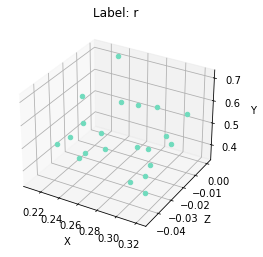

In [139]:
num = 10
example = data[0][num]
label = data[1][num]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for vec in example:
    ax.scatter(vec[0], vec[2], vec[1], c=[color])

plt.title(f'Label: {classes[label]}')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')

plt.show()

## Train Neural Network

### Set Hyperparameters

In [140]:
epochs = 10
val_split = .2

### Labels to One Hot

In [141]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train.astype(int))
y_test = to_categorical(y_test.astype(int))

print(y_train.shape)
print(y_test.shape)

(4246, 24)
(1062, 24)


### Create Callbacks

In [142]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_acc',
                           restore_best_weights=True,
                           patience=10,
                           verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_acc',
                              factor=0.2,
                              min_lr=0.00001,
                              patience=5,
                              verbose=1)

### Create Model

In [143]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, AlphaDropout

model = Sequential(name="Deep_FLAI_6")

model.add(Dense(1024, 
                kernel_initializer="lecun_normal", 
                bias_initializer="zeros", 
                activation='selu',
                input_shape=x_train[0].shape))
model.add(AlphaDropout(0.05))
model.add(Dense(512, 
                kernel_initializer="lecun_normal", 
                bias_initializer="zeros", 
                activation='selu'))
model.add(AlphaDropout(0.05))
model.add(Dense(256, 
                kernel_initializer="lecun_normal", 
                bias_initializer="zeros", 
                activation='selu'))
model.add(AlphaDropout(0.05))
model.add(Dense(128, 
                kernel_initializer="lecun_normal", 
                bias_initializer="zeros", 
                activation='selu'))
model.add(AlphaDropout(0.05))
model.add(Dense(64, 
                kernel_initializer="lecun_normal", 
                bias_initializer="zeros", 
                activation='selu'))
model.add(AlphaDropout(0.05))
model.add(Dense(y_train[0].shape[0], activation='softmax'))

model.summary()

Model: "Deep_FLAI_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 1024)              65536     
_________________________________________________________________
alpha_dropout_42 (AlphaDropo (None, 1024)              0         
_________________________________________________________________
dense_51 (Dense)             (None, 512)               524800    
_________________________________________________________________
alpha_dropout_43 (AlphaDropo (None, 512)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 256)               131328    
_________________________________________________________________
alpha_dropout_44 (AlphaDropo (None, 256)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 128)               

### Train Model

In [144]:
from tensorflow.keras.optimizers import Adam

adam = Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['acc'])

history = model.fit(x_train, y_train,
                      epochs=100,
                      batch_size=32,
                      validation_split=val_split,
                      callbacks=[early_stop, reduce_lr])

Epoch 1/100
107/107 [==============================] - 2s 13ms/step - loss: 3.5270 - acc: 0.0718 - val_loss: 1.8902 - val_acc: 0.3341
Epoch 2/100
107/107 [==============================] - 1s 9ms/step - loss: 1.9942 - acc: 0.3159 - val_loss: 0.9751 - val_acc: 0.5906
Epoch 3/100
107/107 [==============================] - 1s 9ms/step - loss: 1.4309 - acc: 0.4424 - val_loss: 0.7657 - val_acc: 0.7106
Epoch 4/100
107/107 [==============================] - 1s 13ms/step - loss: 1.1975 - acc: 0.5363 - val_loss: 0.7387 - val_acc: 0.6929
Epoch 5/100
107/107 [==============================] - 1s 13ms/step - loss: 1.0249 - acc: 0.6092 - val_loss: 0.8304 - val_acc: 0.6671
Epoch 6/100
107/107 [==============================] - 1s 12ms/step - loss: 1.0004 - acc: 0.6183 - val_loss: 0.8567 - val_acc: 0.6765
Epoch 7/100
107/107 [==============================] - 1s 13ms/step - loss: 1.0400 - acc: 0.6012 - val_loss: 0.5714 - val_acc: 0.7647
Epoch 8/100
107/107 [==============================] - 1s 13ms/s

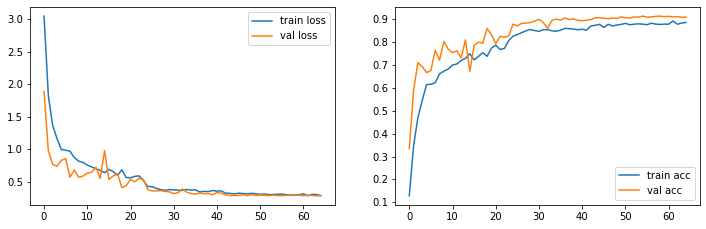

In [145]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['acc'], label='train acc')
plt.plot(history.history['val_acc'], label='val acc')
plt.legend()

### Save Model

In [146]:
model.save(f'{model.name}.h5')

## Store Variables

In [147]:
model_name = model.name
%store x_test
%store y_test
%store model_name
%store classes
del x_test
del y_test
del model_name
del classes

Stored 'x_test' (ndarray)
Stored 'y_test' (ndarray)
Stored 'model_name' (str)
Stored 'classes' (ndarray)
